In [47]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt
import reedsolo

%matplotlib inline

In [48]:
IMG_DIR = 'Images/'

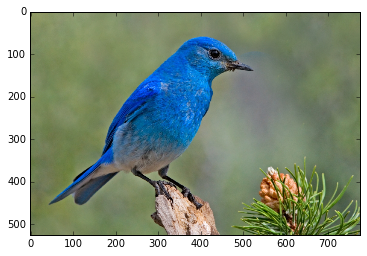

In [49]:
img = ndimage.imread(IMG_DIR+'bird.jpg')
plt.imshow(img)
plt.show()

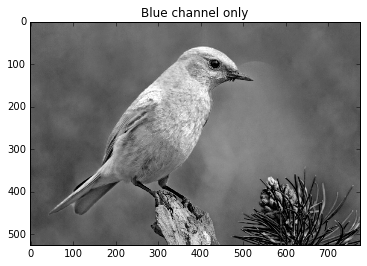

(525, 775)


In [50]:
imgB = img[:,:,2]
plt.imshow(imgB, cmap='gray')
plt.title("Blue channel only")
plt.show()

print imgB.shape

In [51]:
def DCT_2D(x, blockdim=(8,8)):
    out = np.zeros(x.shape)
    for i in xrange(0, x.shape[0], blockdim[0]):
        for j in xrange(0, x.shape[1], blockdim[1]):
            block = x[i:i+blockdim[0], j:j+blockdim[1]]
            block = fftpack.dct(block, type=2, axis=0)
            out[i:i+blockdim[0], j:j+blockdim[1]] = fftpack.dct(block, type=2, axis=1)
            
    return out

def IDCT_2D(x, blockdim=(8,8)):
    out = np.zeros(x.shape)
    for i in xrange(0, x.shape[0], blockdim[0]):
        for j in xrange(0, x.shape[1], blockdim[1]):
            block = x[i:i+blockdim[0], j:j+blockdim[1]]
            block = fftpack.dct(block, type=3, axis=0)
            out[i:i+blockdim[0], j:j+blockdim[1]] = fftpack.dct(block, type=3, axis=1)
            
    return out
            

In [52]:
n = np.arange(64).reshape((8,8))
nc = DCT_2D(n)
nr = IDCT_2D(nc)

print n
print nc
print nr//256   # Need to add a normalization factor???

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]
[[  8.06400000e+03  -4.12308673e+02   0.00000000e+00  -4.31011073e+01
    0.00000000e+00  -1.28577858e+01   0.00000000e+00  -3.24494866e+00]
 [ -3.29846939e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.44808858e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.02862287e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00

In [53]:
def RGB2YCbCr(img):
    # Full range RGB/YCbCr conversion
    A = np.array([[[0, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]]])
    
    return y, cb, cr

def YCbCr(y, cb, cr):
    # Full range RGB/YCbCr conversion
    
    return

In [54]:
def genZigZag(n):
    # Ascending
    swap = 0
    for idxSum in range(n):
        x = 0 if swap else idxSum
        y = idxSum if swap else 0
        if swap:
            while y >= 0:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= 0:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
    
    #Decending
    floor = 1
    for idxSum in range(n, 2*n-1):
        x = floor if swap else n-1
        y = n-1 if swap else floor
        if swap:
            while y >= floor:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= floor:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
        floor += 1

class JPEG(object):
    def __init__(self, img, qtable, QF=4, dims=None):
        self.raw = img
        self.qtable = qtable*QF
        self.dims = img.shape if dims is None else dims
        self.zstride = list(genZigZag(8))
        self.linstride = list(range(64))
        
        # Forward path - attributes used in compression
                                    # Original image shape: NxM
        self.transformed = None     # shape: NxM
        self.quantized = None       # shape: NxM
        self.flattened = None       # shape: (N*M/64)x64
        self.compressed = None      # shape: ???
        
        # Reverse path - attributes used in decompression
                                    # Original data shape: ???
        self.decompressed = None    # shape: (N*M/64)x64
        self.expanded = None        # shape: NxM
        self.rectified = None       # shape: NxM
        self.reconstructed = None   # shape: NxM
        
    def process(self):
        self.DCT_2D()
        self.quantizeBlocks()
        self.flattenBlocks()
        self.compress()
        return self.compressed
    
    def unprocess(self):
        self.decompress()
        self.expandBlocks()
        self.rectifyBlocks()
        self.IDCT_2D()
        return self.reconstructed

    def DCT_2D(self, inarr=None):
        if inarr is None:
            inarr = self.raw
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                block = fftpack.dct(block, type=2, axis=0)
                out[i:i+8, j:j+8] = fftpack.dct(block, type=2, axis=1)

        self.transformed = out

    def IDCT_2D(self, inarr=None):
        if inarr is None:
            inarr = self.rectified
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                block = fftpack.dct(block, type=3, axis=0)
                out[i:i+8, j:j+8] = fftpack.dct(block, type=3, axis=1)

        self.reconstructed = np.true_divide(out, 256)
        
    def quantizeBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.transformed
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = np.floor_divide(block, self.qtable)
                
        self.quantized = out
    
    def rectifyBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.expanded
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = np.multiply(block, self.qtable)
                
        self.rectified = out
        
    def flattenBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.quantized
        nBlocks = (self.dims[0]//8, self.dims[1]//8)
        out = np.zeros((nBlocks[0]*nBlocks[1], 64))
    
        for bx in xrange(nBlocks[0]):
            for by in xrange(nBlocks[1]):
                for i, z in zip(self.linstride, self.zstride):
                    out[nBlocks[1]*bx+by, i] = inarr[bx*8+z[0], by*8+z[1]]
                    
        self.flattened = out
    
    def expandBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.decompressed
        nBlocks = (self.dims[0]//8, self.dims[1]//8)
        out = np.zeros(self.dims)

        for bx in xrange(nBlocks[0]):
            for by in xrange(nBlocks[1]):
                for i, z in zip(self.linstride, self.zstride):
                    out[bx*8+z[0], by*8+z[1]] = inarr[nBlocks[1]*bx+by, i]
                    
        self.expanded = out
        
    def compress(self, inarr=None):
        self.compressed = self.flattened
    
    def decompress(self, inarr=None):
        self.decompressed = self.raw


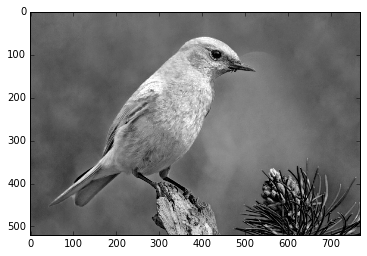

In [55]:
imgIn = imgB[:520,:768]
# imgIn = np.ones((520, 768))*255
# Suggested Y-channel quantization table by JPEG standard
q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

j = JPEG(imgIn, q)
imgProc = j.process()
imgProc = j.flattened

plt.imshow(imgIn, cmap='gray')
plt.show()

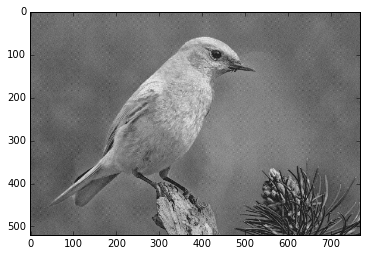

In [56]:
jI = JPEG(imgProc, q, dims=imgIn.shape)
imgOut = jI.unprocess()

plt.imshow(imgOut, cmap='gray')
plt.show()

In [57]:
print np.max(imgOut)
print np.min(imgOut)

print np.max(j.flattened)
print np.min(j.flattened)

294.210929557
-43.4447175574
988.0
-270.0


In [58]:
import Encoding

In [59]:
reload(Encoding)
testing = j.flattened

# jank solution for bounding values
# DCValues = testing[:, 0]
# ACValues = DCT[:,1:]
# testing = (testing.astype('float64')/np.max(testing) * 1022.0).astype('int')

print Encoding.huffmanLookupChrominanceDC
inspect = Encoding.DCPM(testing[:, 0] )
e = Encoding.encode(testing, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)


{0: '00', 1: '01', 2: '10', 3: '110', 4: '1110', 5: '11110', 6: '111110', 7: '1111110', 8: '11111110', 9: '111111110', 10: '1111111110', 11: '11111111110', 12: '111111111110'}


In [66]:
print testing.shape[0] * testing.shape[1]*8
print len(e)

3194880
1140067


In [67]:
reload(Encoding)
d = Encoding.decode(e, Encoding.huffmanRootChrominanceDC, Encoding.huffmanRootChrominanceAC)

In [68]:
print testing - d

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
